<a href="https://colab.research.google.com/github/changsin/FSDL/blob/main/plate_recognizer/notebooks/data_centric_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UFPR license plate dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!git clone https://github.com/changsin/FSDL

fatal: destination path 'FSDL' already exists and is not an empty directory.


In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from importlib.util import find_spec
if find_spec("plate_recognizer") is None:
    import sys
    sys.path.append('..')

from FSDL.plate_recognizer.data.kaggle_data import KaggleData
from FSDL.plate_recognizer.data.cluster import Cluster

import os
import glob

DATA_ROOT = "./drive/MyDrive/data/DataCentric/train/"

IMAGE_SIZE = 224

##### log path is /content #####
##### log path is /content #####
##### log path is /content #####


In [3]:
def glob_files(path):
    search_string = os.path.join(path,'*')
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

In [21]:
import cv2

def load_images(path):
  paths = glob_files(path)

  X_raw = []
  for file in paths:
    image = cv2.imread(file)
    image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
    X_raw.append(np.array(image))

  return np.array(X_raw)

X_train_raw = load_images(DATA_ROOT)

In [23]:
X_train_raw = X_train_raw / 255.0

In [ ]:
X_train_raw[0]

In [25]:
from FSDL.plate_recognizer.data.cluster import Cluster

K = 10

cluster = Cluster()

X_train_reduced, pca = cluster.get_pca_reduced(X_train_raw)

X_train_clusters, kmeans_x_train = cluster.get_clusters(X_train_reduced, K)

In [34]:
def plot_pca_clusters(X_train_pca, kmeans):
    # kmeans, X_train_pca_clusters = get_clusters(X_train_pca)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

    # print(x_min, x_max, y_min, y_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(2)
    # plt.clf()
    plt.imshow(Z, interpolation="nearest",
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                cmap=plt.cm.Paired, aspect="auto", origin="lower")

    plt.plot(X_train_pca[:, 0], X_train_pca[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_

    # markers = ["o", "1", "2", "3", "4"]
    for id in range(len(centroids)):
        c = centroids[id]
        plt.scatter(c[0], c[1], s=169, linewidths=3,
                    color="w", zorder=10)

    # plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
    #             color="w", zorder=10)
    # https://matplotlib.org/2.0.2/api/markers_api.html#module-matplotlib.markers
    plt.title("K-means clustering on the PCA-reduced data\n"
                "Centroids 0-o, 1-down, 2-up, 3-left, 4-right tri")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()


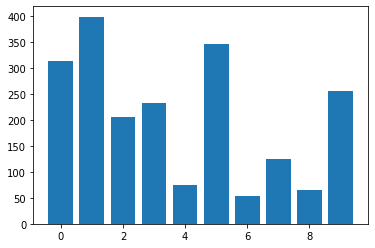

In [31]:
import FSDL.plate_recognizer.utils.plots as plots

# plots.plot_pca_clusters(X_train_reduced, kmeans_x_train)
plots.plot_cluster_histogram(X_train_clusters, K)

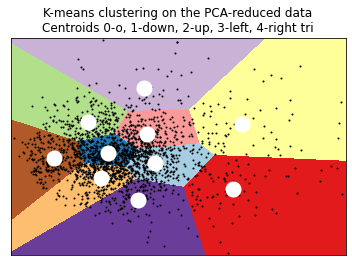

In [35]:
plot_pca_clusters(X_train_reduced, kmeans_x_train)


No handles with labels found to put in legend.


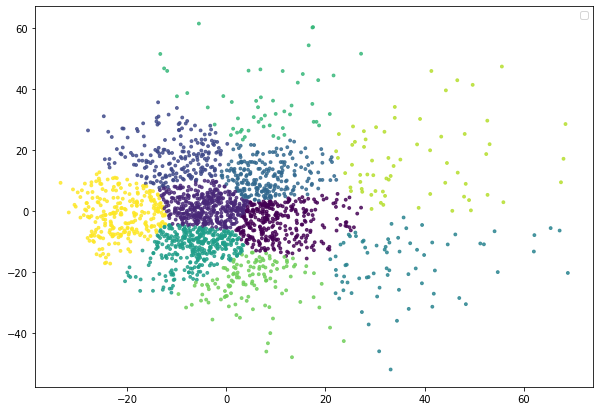

In [53]:
import seaborn as sns

plt.figure(figsize=(10,7))
plt.scatter(X_train_reduced[:, 0] , X_train_reduced[:, 1], c=kmeans_x_train.labels_ , alpha=0.8, s=8)

plt.legend()
plt.show()

In [38]:
def get_clusters(X_train_pca, K):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_train_pca_clusters = kmeans.fit(X_train_pca)

  return X_train_pca_clusters, kmeans

X_clusters, kmean = cluster.get_clusters(X_train_reduced, K)

In [39]:
X_clusters

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
from FSDL.plate_recognizer.data.kaggle_data import KaggleData
from FSDL.plate_recognizer.data.cluster import Cluster

DATA_ROOT = "./drive/MyDrive/data/UFPR_YOLO/"

ufpr_data = KaggleData(X_path=DATA_ROOT+"images/train/", Y_path=DATA_ROOT+"labels/annotations_train.json")
ufpr_data.prepare_data()
ufpr_data.cluster_data(unique=False)
ufpr_data.partition_on_clusters()
ufpr_data.X.shape

(1800, 224, 224, 3)

## Save annotation files -one time
This is a one time loading and saving of annotation files to save time. After the files are loaded into Y_raw, it was serialized into json file. Later this file can be just loaded and deserialized which is much faster. 

In [ ]:
IMAGE_SIZE = 224
Y_raw = ufpr_data.load_labels(DATA_ROOT+"labels/annotations_train.json")
Y_raw = [[int(e*IMAGE_SIZE) for e in y] for y in Y_raw]
ufpr_data.to_json(DATA_ROOT+"labels/annotations_train.json", Y_raw)

In [ ]:
ufpr_data.test_idx

{0: array([ 749, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059,
        1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070,
        1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1140, 1141,
        1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152,
        1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163,
        1164, 1165, 1166, 1167, 1168, 1169, 1230, 1231, 1232, 1233, 1234,
        1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245,
        1246, 1247, 1248, 1249]),
 1: array([1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546,
        1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557,
        1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568,
        1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579,
        1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590,
        1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601